# Performance tricks in OpenVINO for latency mode

The goal of this notebook is to provide a step-by-step tutorial for improving performance for inferencing in a latency mode. Low latency is especially desired in real-time applications when the results are needed as soon as possible after the data appears. This notebook assumes computer vision workflow and uses [YOLOv5n](https://github.com/ultralytics/yolov5) model. We will simulate a camera application that provides frames one by one.

The performance tips applied in this notebook could be summarized in the following figure. Some of the steps below can be applied to any device at any stage, e.g., "shared_memory"; some can be used only to specific devices, e.g., "inference num threads" to CPU. As the number of potential configurations is vast, we recommend looking at the steps below and then apply a trial-and-error approach. You can incorporate many hints simultaneously, like more inference threads + shared memory. It should give even better performance, but we recommend testing it anyway.

> **NOTE**: We especially recommend trying `OpenVINO IR model + CPU + shared memory in latency mode` or `OpenVINO IR model + CPU + shared memory + more inference threads`.

The quantization and pre-post-processing API are not included here as they change the precision (quantization) or processing graph (prepostprocessor). You can find examples of how to apply them to optimize performance on OpenVINO IR files in [111-detection-quantization](../111-detection-quantization) and [118-optimize-preprocessing](../118-optimize-preprocessing).

![](https://user-images.githubusercontent.com/4547501/229120774-01f4f972-424d-4280-8395-220dd432985a.png)

> **NOTE**: Many of the steps presented below will give you better performance. However, some of them may not change anything if they are strongly dependent on either the hardware or the model. Please run this notebook on your computer with your model to learn which of them makes sense in your case.

## Prerequisites

In [1]:
!pip install -q seaborn ultralytics

In [2]:
import os
import sys
import time
from pathlib import Path
from typing import Any, List, Tuple

sys.path.append("../utils")
import notebook_utils as utils

## Data

We will use the same image of the dog sitting on a bicycle for all experiments below. The image is resized and preprocessed to fulfill the requirements of this particular object detection model.

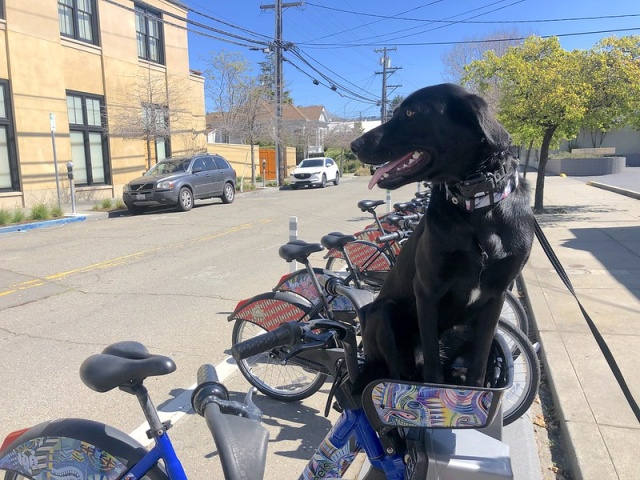

<DisplayHandle display_id=1c1434fd76c562587b3a22b82bd2624b>

In [3]:
import numpy as np
import cv2

IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480

# load image
image = utils.load_image("../data/image/coco_bike.jpg")
image = cv2.resize(image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)

# preprocess it for YOLOv5
input_image = image / 255.0
input_image = np.transpose(input_image, axes=(2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

# show the image
utils.show_array(image)

## Model

We decided to go with [YOLOv5n](https://github.com/ultralytics/yolov5), one of the state-of-the-art object detection models, easily available through the PyTorch Hub and small enough to see the difference in performance.

In [5]:
import torch
from IPython.utils import io

# directory for all models
base_model_dir = Path("model")

model_name = "yolov5n"
model_path = base_model_dir / model_name

# load YOLOv5n from PyTorch Hub
pytorch_model = torch.hub.load("ultralytics/yolov5", "custom", path=model_path, device="cpu", skip_validation=True)
# don't print full model architecture
with io.capture_output():
    pytorch_model.eval()

Using cache found in /home/apulache/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-29 Python-3.10.12 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


## Hardware

The code below lists the available hardware we will use in the benchmarking process.

> **NOTE**: The hardware you have is probably completely different from ours. It means you can see completely different results.

In [6]:
import openvino.runtime as ov

# initialize OpenVINO
core = ov.Core()

# print available devices
for device in core.available_devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz
GPU: Intel(R) UHD Graphics [0x9bca] (iGPU)


## Helper functions

We're defining a benchmark model function to use for all optimized models below. It runs inference 1000 times, averages the latency time, and prints two measures: seconds per image and frames per second (FPS).

In [7]:
INFER_NUMBER = 1000


def benchmark_model(model: Any, input_data: np.ndarray, benchmark_name: str, device_name: str = "CPU") -> float:
    """
    Helper function for benchmarking the model. It measures the time and prints results.
    """
    # measure the first inference separately -  it may be slower as it contains also initialization
    start = time.perf_counter()
    model(input_data)
    end = time.perf_counter()
    first_infer_time = end - start
    print(f"{benchmark_name} on {device_name}. First inference time: {first_infer_time :.4f} seconds")

    # benchmarking
    start = time.perf_counter()
    for _ in range(INFER_NUMBER):
        model(input_data)
    end = time.perf_counter()

    # elapsed time
    infer_time = end - start

    # print second per image and FPS
    mean_infer_time = infer_time / INFER_NUMBER
    mean_fps = INFER_NUMBER / infer_time
    print(f"{benchmark_name} on {device_name}: {mean_infer_time :.4f} seconds per image ({mean_fps :.2f} FPS)")

    return mean_infer_time

The following functions aim to post-process results and draw boxes on the image.

In [8]:
# https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda
classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
    "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard",
    "cell phone", "microwave", "oven", "oaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()


def postprocess(detections: np.ndarray) -> List[Tuple]:
    """
    Postprocess the raw results from the model.
    """
    # candidates - probability > 0.25
    detections = detections[detections[..., 4] > 0.25]

    boxes = []
    labels = []
    scores = []
    for obj in detections:
        xmin, ymin, ww, hh = obj[:4]
        score = obj[4]
        label = np.argmax(obj[5:])
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin - ww // 2, ymin - hh // 2, ww, hh)))
        )
        labels.append(int(label))
        scores.append(float(score))

    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=0.25, nms_threshold=0.5
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


def draw_boxes(img: np.ndarray, boxes):
    """
    Draw detected boxes on the image.
    """
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=img, pt1=box[:2], pt2=(x2, y2), color=color, thickness=2)

        # Draw a label name inside the box.
        cv2.putText(
            img=img,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 20),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=img.shape[1] / 1200,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )


def show_result(results: np.ndarray):
    """
    Postprocess the raw results, draw boxes and show the image.
    """
    output_img = image.copy()

    detections = postprocess(results)
    draw_boxes(output_img, detections)

    utils.show_array(output_img)

## Optimizations

Below, we present the performance tricks for faster inference in the latency mode. We release resources after every benchmarking to be sure the same amount of resource is available for every experiment.

### PyTorch model

First, we're benchmarking the original PyTorch model without any optimizations applied. We will treat it as our baseline.

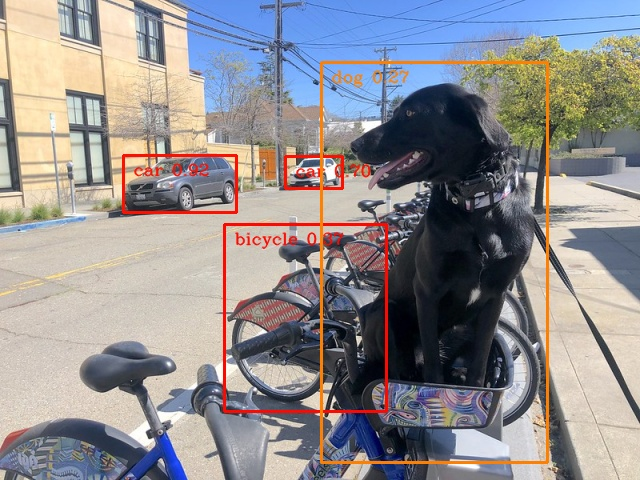

PyTorch model on CPU. First inference time: 0.0285 seconds
PyTorch model on CPU: 0.0252 seconds per image (39.69 FPS)


In [9]:
import torch

with torch.no_grad():
    result = pytorch_model(torch.as_tensor(input_image)).detach().numpy()[0]
    show_result(result)
    pytorch_infer_time = benchmark_model(pytorch_model, input_data=torch.as_tensor(input_image).float(), benchmark_name="PyTorch model")

### ONNX model

The first optimization is exporting the PyTorch model to ONNX and running it in OpenVINO. It's possible, thanks to the ONNX frontend. It means we don't necessarily have to convert the model to Intermediate Representation (IR) to leverage the OpenVINO Runtime.

In [10]:
onnx_path = base_model_dir / Path(f"{model_name}_{IMAGE_WIDTH}_{IMAGE_HEIGHT}").with_suffix(".onnx")

# export PyTorch model to ONNX if it doesn't already exist
if not onnx_path.exists():
    dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    torch.onnx.export(pytorch_model, dummy_input, onnx_path)

# load and compile in OpenVINO
onnx_model = core.read_model(onnx_path)
onnx_model = core.compile_model(onnx_model, device_name="CPU")

/home/apulache/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:515: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  y = self.model(im, augment=augment, visualize=visualize) if augment or visualize else self.model(im)
/home/apulache/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:64: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


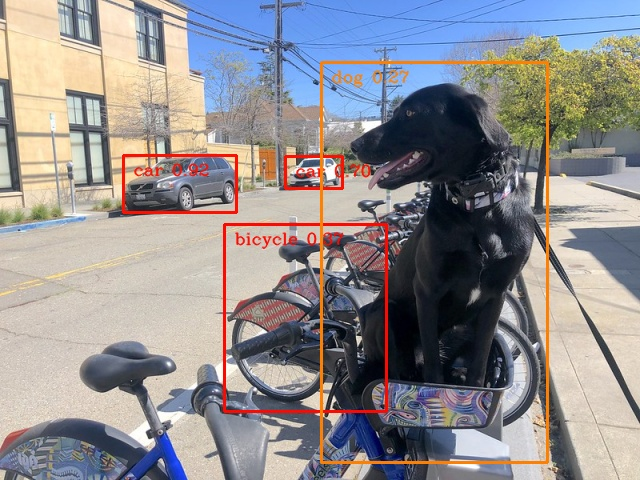

ONNX model on CPU. First inference time: 0.0203 seconds
ONNX model on CPU: 0.0151 seconds per image (66.42 FPS)


In [11]:
result = onnx_model(input_image)[onnx_model.output(0)][0]
show_result(result)
onnx_infer_time = benchmark_model(model=onnx_model, input_data=input_image, benchmark_name="ONNX model")

del onnx_model  # release resources

### OpenVINO IR model

Let's convert the ONNX model to OpenVINO Intermediate Representation (IR) FP16 and run it. Reducing the precision is one of the well-known methods for faster inference provided the hardware that supports lower precision, such as FP16 or even INT8. If the hardware doesn't support lower precisions, the model will be inferred in FP32 automatically. We could also use quantization (INT8), but we should experience a little accuracy drop. That's why we skip that step in this notebook.

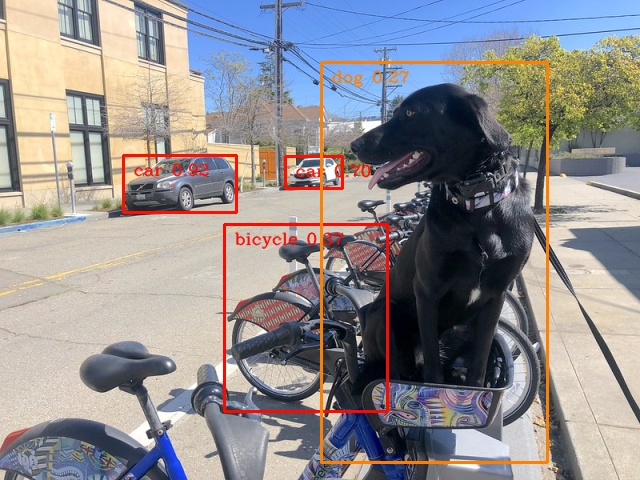

OpenVINO model on CPU. First inference time: 0.0192 seconds
OpenVINO model on CPU: 0.0153 seconds per image (65.26 FPS)


In [12]:
from openvino.tools import mo

ov_model = mo.convert_model(onnx_path, compress_to_fp16=True)
# save the model on disk
ov.serialize(ov_model, xml_path=str(onnx_path.with_suffix(".xml")))

ov_cpu_model = core.compile_model(ov_model, device_name="CPU")

result = ov_cpu_model(input_image)[ov_cpu_model.output(0)][0]
show_result(result)
ov_cpu_infer_time = benchmark_model(model=ov_cpu_model, input_data=input_image, benchmark_name="OpenVINO model")

del ov_cpu_model  # release resources

### OpenVINO IR model on GPU

Usually, a GPU device is faster than a CPU, so let's run the above model on the GPU. Please note you need to have an Intel GPU and [install drivers](https://github.com/openvinotoolkit/openvino_notebooks/wiki/Ubuntu#1-install-python-git-and-gpu-drivers-optional) to be able to run this step. In addition, offloading to the GPU helps reduce CPU load and memory consumption, allowing it to be left for routine processes. If you cannot observe a faster inference on GPU, it may be because the model is too light to benefit from massive parallel execution.

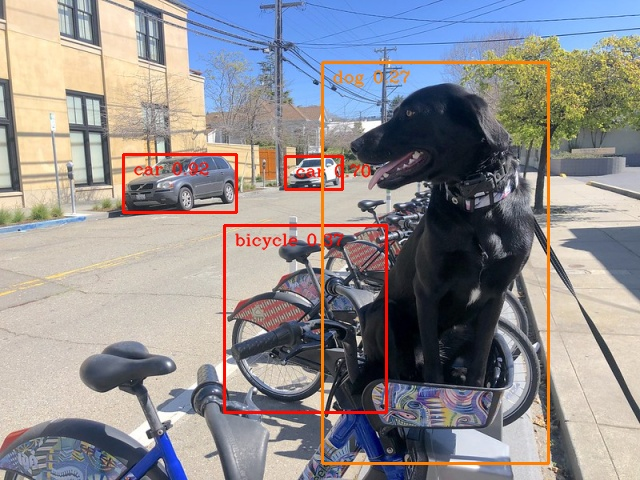

OpenVINO model on GPU. First inference time: 0.0195 seconds
OpenVINO model on GPU: 0.0166 seconds per image (60.19 FPS)


In [13]:
ov_gpu_infer_time = 0.0
if "GPU" in core.available_devices:
    ov_gpu_model = core.compile_model(ov_model, device_name="GPU")

    result = ov_gpu_model(input_image)[ov_gpu_model.output(0)][0]
    show_result(result)
    ov_gpu_infer_time = benchmark_model(model=ov_gpu_model, input_data=input_image, benchmark_name="OpenVINO model", device_name="GPU")

    del ov_gpu_model  # release resources

### OpenVINO IR model + more inference threads

There is a possibility to add a config for any device (CPU in this case). We will increase the number of threads to an equal number of our cores. It should help us a lot. There are [more options](https://docs.openvino.ai/2023.0/groupov_runtime_cpp_prop_api.html) to be changed, so it's worth playing with them to see what works best in our case.

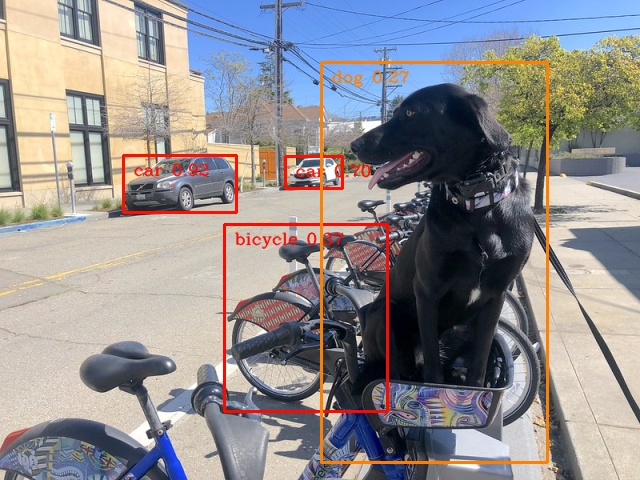

OpenVINO model + more threads on CPU. First inference time: 0.0188 seconds
OpenVINO model + more threads on CPU: 0.0151 seconds per image (66.15 FPS)


In [14]:
num_cores = os.cpu_count()

ov_cpu_config_model = core.compile_model(ov_model, device_name="CPU", config={"INFERENCE_NUM_THREADS": num_cores})

result = ov_cpu_config_model(input_image)[ov_cpu_config_model.output(0)][0]
show_result(result)
ov_cpu_config_infer_time = benchmark_model(model=ov_cpu_config_model, input_data=input_image, benchmark_name="OpenVINO model + more threads")

del ov_cpu_config_model  # release resources

### OpenVINO IR model in latency mode

OpenVINO offers a virtual device called [AUTO](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_supported_plugins_AUTO.html), which can select the best device for us based on a performance hint. There are three different hints: `LATENCY`, `THROUGHPUT`, and `CUMULATIVE_THROUGHPUT`. As this notebook is focused on the latency mode, we will use `LATENCY`. The above hints can be used with other devices as well.

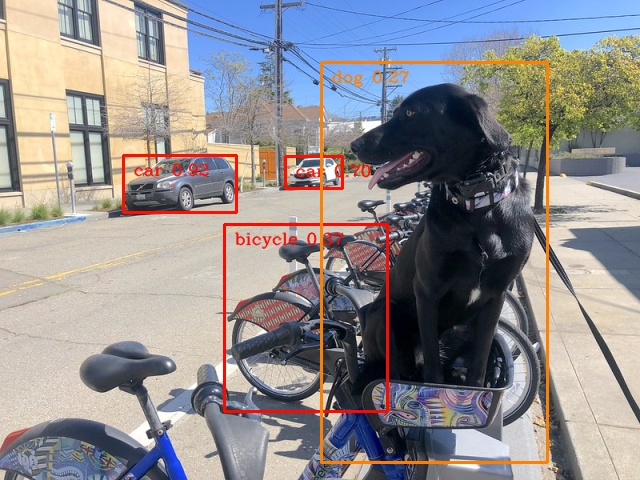

OpenVINO model on AUTO. First inference time: 0.0327 seconds
OpenVINO model on AUTO: 0.0177 seconds per image (56.37 FPS)


In [15]:
ov_auto_model = core.compile_model(ov_model, device_name="AUTO", config={"PERFORMANCE_HINT": "LATENCY"})

result = ov_auto_model(input_image)[ov_auto_model.output(0)][0]
show_result(result)
ov_auto_infer_time = benchmark_model(model=ov_auto_model, input_data=input_image, benchmark_name="OpenVINO model", device_name="AUTO")

### OpenVINO IR model in latency mode + shared memory

OpenVINO is a C++ toolkit with Python wrappers (API). The default behavior in the Python API is copying the input to the additional buffer and then running processing in C++, which prevents many multiprocessing-related issues. However, it also increases time cost. We can create a tensor with enabled shared memory (keeping in mind we cannot overwrite our input), save time for copying and improve the performance!

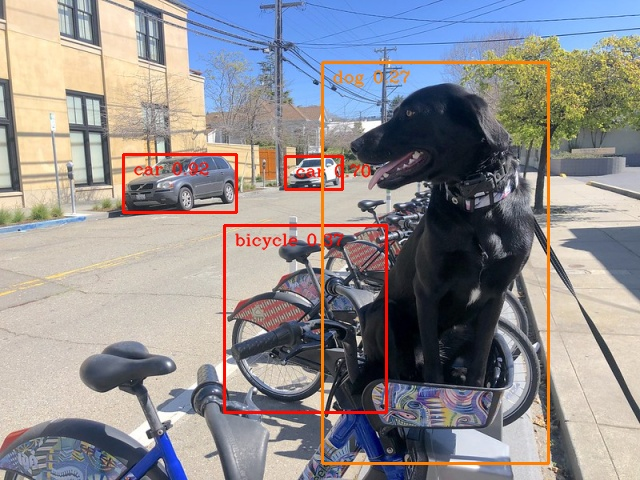

OpenVINO model + shared memory on AUTO. First inference time: 0.0147 seconds
OpenVINO model + shared memory on AUTO: 0.0143 seconds per image (69.96 FPS)


In [16]:
# it must be assigned to a variable, not to be garbage collected
c_input_image = np.ascontiguousarray(input_image, dtype=np.float32)
input_tensor = ov.Tensor(c_input_image, shared_memory=True)

result = ov_auto_model(input_tensor)[ov_auto_model.output(0)][0]
show_result(result)
ov_auto_shared_infer_time = benchmark_model(model=ov_auto_model, input_data=input_tensor, benchmark_name="OpenVINO model + shared memory", device_name="AUTO")

del ov_auto_model  # release resources

### Other tricks

There are other tricks for performance improvement, especially quantization and prepostprocessing. To get even more from your model, please visit [111-detection-quantization](../111-detection-quantization) and [118-optimize-preprocessing](../118-optimize-preprocessing).

## Performance comparison

The following graphical comparison is valid for the selected model and hardware simultaneously. If you cannot see any improvement between some steps, just skip them.

In [17]:
%matplotlib inline

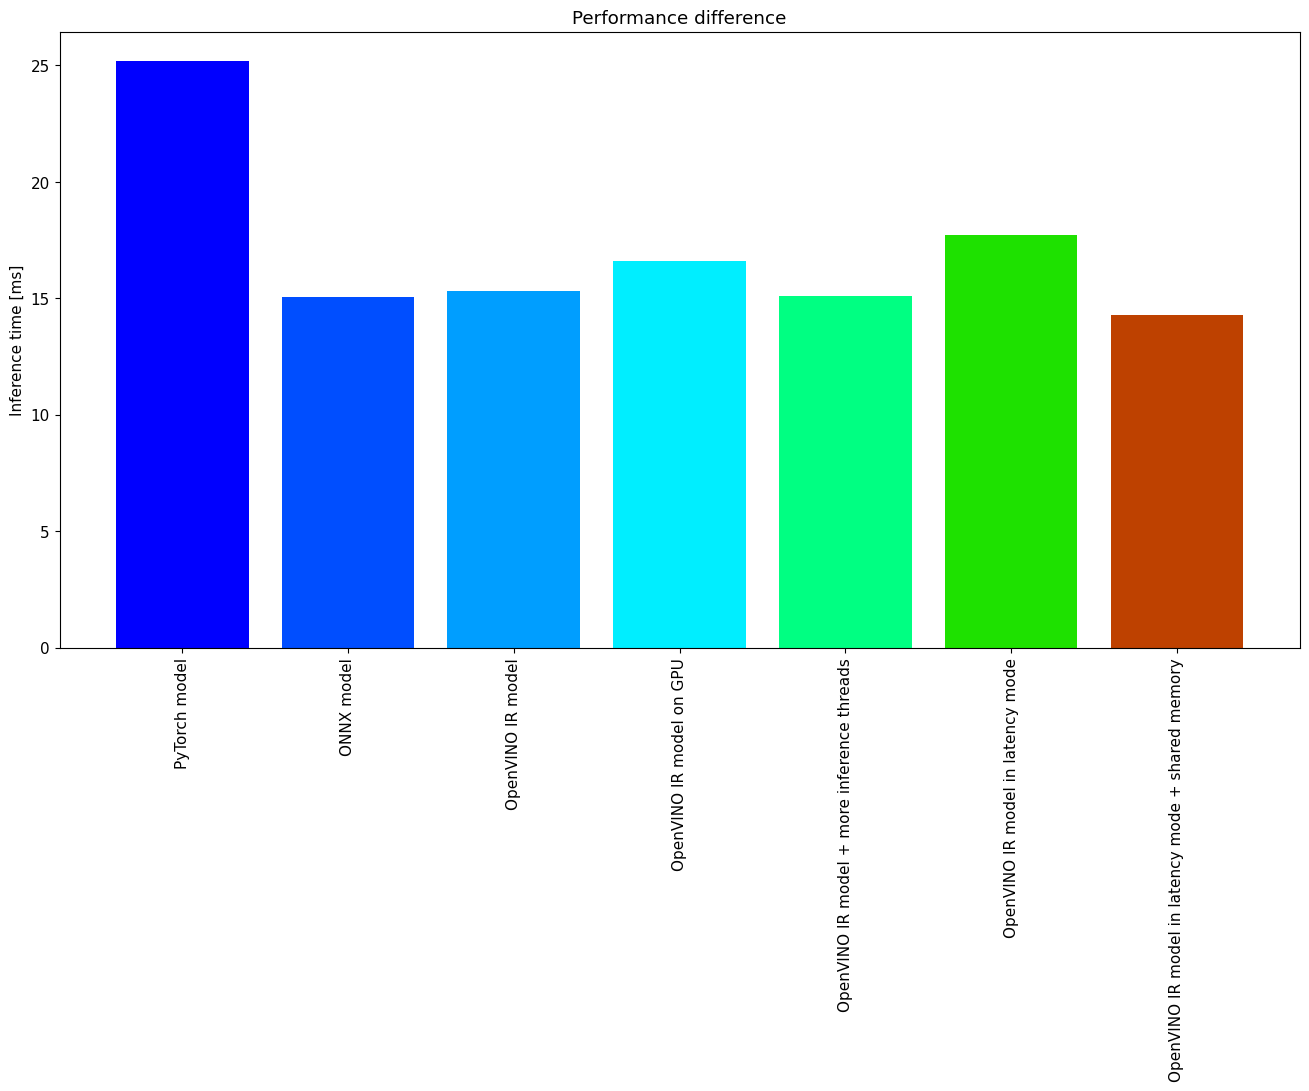

In [18]:
from matplotlib import pyplot as plt

labels = ["PyTorch model", "ONNX model", "OpenVINO IR model", "OpenVINO IR model on GPU", "OpenVINO IR model + more inference threads",
          "OpenVINO IR model in latency mode", "OpenVINO IR model in latency mode + shared memory"]
# make them milliseconds
times = list(map(lambda x: 1000 * x, [pytorch_infer_time, onnx_infer_time, ov_cpu_infer_time, ov_gpu_infer_time, ov_cpu_config_infer_time,
                                      ov_auto_infer_time, ov_auto_shared_infer_time]))

bar_colors = colors[::10] / 255.0

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(labels, times, color=bar_colors)

ax.set_ylabel("Inference time [ms]")
ax.set_title("Performance difference")

plt.xticks(rotation='vertical')
plt.show()

## Conclusions

We already showed the steps needed to improve the performance of an object detection model. Even if you experience much better performance after running this notebook, please note this may not be valid for every hardware or every model. For the most accurate results, please use `benchmark_app` [command-line tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_samples_benchmark_app_README.html). Note that `benchmark_app` cannot measure the impact of some tricks above, e.g., shared memory.